In [63]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
df = pd.read_csv('../../data/df_final.csv',index_col='date', parse_dates=True)

In [58]:
df

,eurusd,jpyusd,gbpusd,nq,sp500,nikkei,ftse,gdp_us,gdp_uk,gdp_jp,...,ir_us,ir_uk,ir_ez,ir_jp,eurusd_pct_change,jpyusd_pct_change,gbpusd_pct_change,eurusd_trend,jpyusd_trend,gbpusd_trend
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,1.258194,0.009320,1.785204,1468.00,1111.920044,10676.639648,4476.899902,11923447.0,322790.0,529365100.0,...,1.0,3.75,2.0,0.1,-0.000642,0.000932,-0.002017,down,up,down
2004-01-02,1.258194,0.009354,1.793690,1466.50,1108.479980,10676.639648,4510.200195,11923447.0,322790.0,529365100.0,...,1.0,3.75,2.0,0.1,0.000000,0.003648,0.004753,down,up,up
2004-01-05,1.268698,0.009413,1.807207,1495.50,1122.219971,10825.169922,4513.299805,11923447.0,322790.0,529365100.0,...,1.0,3.75,2.0,0.1,0.008348,0.006307,0.007536,up,up,up
2004-01-06,1.272103,0.009414,1.821295,1504.50,1123.670044,10813.990234,4505.200195,11923447.0,322790.0,529365100.0,...,1.0,3.75,2.0,0.1,0.002684,0.000094,0.007795,up,up,up
2004-01-07,1.264095,0.009418,1.817785,1517.00,1126.329956,10757.820312,4473.000000,11923447.0,322790.0,529365100.0,...,1.0,3.75,2.0,0.1,-0.006295,0.000471,-0.001927,down,up,down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1.066780,0.007531,1.206001,11075.25,3844.820068,26405.869141,7473.000000,26408405.0,645805.0,568061100.0,...,4.1,3.50,2.5,0.3,0.006081,-0.003261,0.001668,up,down,up
2022-12-27,1.064022,0.007532,1.208415,10915.50,3829.250000,26447.869141,7473.000000,26408405.0,645805.0,568061100.0,...,4.1,3.50,2.5,0.3,-0.002586,0.000196,0.002002,down,up,up
2022-12-28,1.063717,0.007491,1.202733,10772.75,3783.219971,26340.500000,7497.200195,26408405.0,645805.0,568061100.0,...,4.1,3.50,2.5,0.3,-0.000287,-0.005409,-0.004703,down,down,down


In [59]:
df['eurusd_trend'] = df['eurusd_trend'].replace({'up': 1, 'down': 0})
df['jpyusd_trend'] = df['eurusd_trend'].replace({'up': 1, 'down': 0})
df['gbpusd_trend'] = df['gbpusd_trend'].replace({'up': 1, 'down': 0})

In [60]:
scaler = MinMaxScaler()
scaler.fit(df)

MinMaxScaler()

In [61]:
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Multiple Linear Regression

## EURUSD

In [64]:
# Definir características y variables target
features = df.drop(columns=['eurusd', 'gbpusd', 'jpyusd'])
targets = ['eurusd', 'gbpusd', 'jpyusd']

In [65]:
# Función para optimizar los hiperparámetros
def objective(trial, X, y, model_type):
    if model_type == 'Linear Regression':
        model = LinearRegression()
    elif model_type == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_type == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
        model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    elif model_type == 'CatBoost':
        iterations = trial.suggest_int('iterations', 100, 1000)
        depth = trial.suggest_int('depth', 2, 10)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
        model = CatBoostRegressor(iterations=iterations, depth=depth, learning_rate=learning_rate, random_state=42, silent=True)
    elif model_type == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        num_leaves = trial.suggest_int('num_leaves', 20, 200)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
        model = LGBMRegressor(n_estimators=n_estimators, num_leaves=num_leaves, learning_rate=learning_rate, random_state=42)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(pipeline, X, y, cv=tscv, scoring=make_scorer(mean_squared_error))
    return scores.mean()

In [66]:
# Función para entrenar y evaluar modelos
def train_and_evaluate(df, target):
    X = df.drop(columns=targets)
    y = df[target]
    
    # Normalizar la variable target
    target_scaler = MinMaxScaler()
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    
    # Definir modelos y sus estudios de optimización
    models = ['Linear Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'LightGBM']
    best_params = {}
    predictions = {}
    
    for model_type in models:
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X, y_scaled, model_type), n_trials=50)
        best_params[model_type] = study.best_params
        
        # Entrenar el modelo con los mejores hiperparámetros
        if model_type == 'Linear Regression':
            model = LinearRegression()
        elif model_type == 'Random Forest':
            model = RandomForestRegressor(**study.best_params, random_state=42)
        elif model_type == 'XGBoost':
            model = XGBRegressor(**study.best_params, random_state=42)
        elif model_type == 'CatBoost':
            model = CatBoostRegressor(**study.best_params, random_state=42, silent=True)
        elif model_type == 'LightGBM':
            model = LGBMRegressor(**study.best_params, random_state=42)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])
        
        pipeline.fit(X, y_scaled)
        preds_scaled = pipeline.predict(X)
        
        # Invertir la normalización de las predicciones
        preds = target_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        predictions[model_type] = preds
    
    return best_params, predictions

In [ ]:
# Entrenar y evaluar los modelos para cada variable target
results = {}
predictions = {}

for target in targets:
    print(f"Evaluando modelos para: {target}")
    res, preds = train_and_evaluate(df, target)
    results[target] = res
    predictions[target] = preds
    for model, params in results[target].items():
        print(f"{model}: {params}")

In [69]:
results_df

,eurusd,gbpusd,jpyusd
Linear Regression,{},{},{}
Random Forest,"{'n_estimators': 11, 'max_depth': 17}","{'n_estimators': 172, 'max_depth': 3}","{'n_estimators': 50, 'max_depth': 25}"
XGBoost,"{'n_estimators': 140, 'max_depth': 2, 'learnin...","{'n_estimators': 113, 'max_depth': 2, 'learnin...","{'n_estimators': 112, 'max_depth': 4, 'learnin..."
CatBoost,"{'iterations': 483, 'depth': 2, 'learning_rate...","{'iterations': 158, 'depth': 5, 'learning_rate...","{'iterations': 729, 'depth': 3, 'learning_rate..."
LightGBM,"{'n_estimators': 57, 'num_leaves': 37, 'learni...","{'n_estimators': 25, 'num_leaves': 22, 'learni...","{'n_estimators': 94, 'num_leaves': 27, 'learni..."


In [68]:
# Crear una tabla con los mejores hiperparámetros
results_df = pd.DataFrame(results)
print("\nMejores hiperparámetros:")
print(results_df)



Mejores hiperparámetros:
                                                              eurusd  \
Linear Regression                                                 {}   
Random Forest                  {'n_estimators': 11, 'max_depth': 17}   
XGBoost            {'n_estimators': 140, 'max_depth': 2, 'learnin...   
CatBoost           {'iterations': 483, 'depth': 2, 'learning_rate...   
LightGBM           {'n_estimators': 57, 'num_leaves': 37, 'learni...   

                                                              gbpusd  \
Linear Regression                                                 {}   
Random Forest                  {'n_estimators': 172, 'max_depth': 3}   
XGBoost            {'n_estimators': 113, 'max_depth': 2, 'learnin...   
CatBoost           {'iterations': 158, 'depth': 5, 'learning_rate...   
LightGBM           {'n_estimators': 25, 'num_leaves': 22, 'learni...   

                                                              jpyusd  
Linear Regression                    

In [71]:
results_df.to_csv('shall_reg_hyperp.csv')

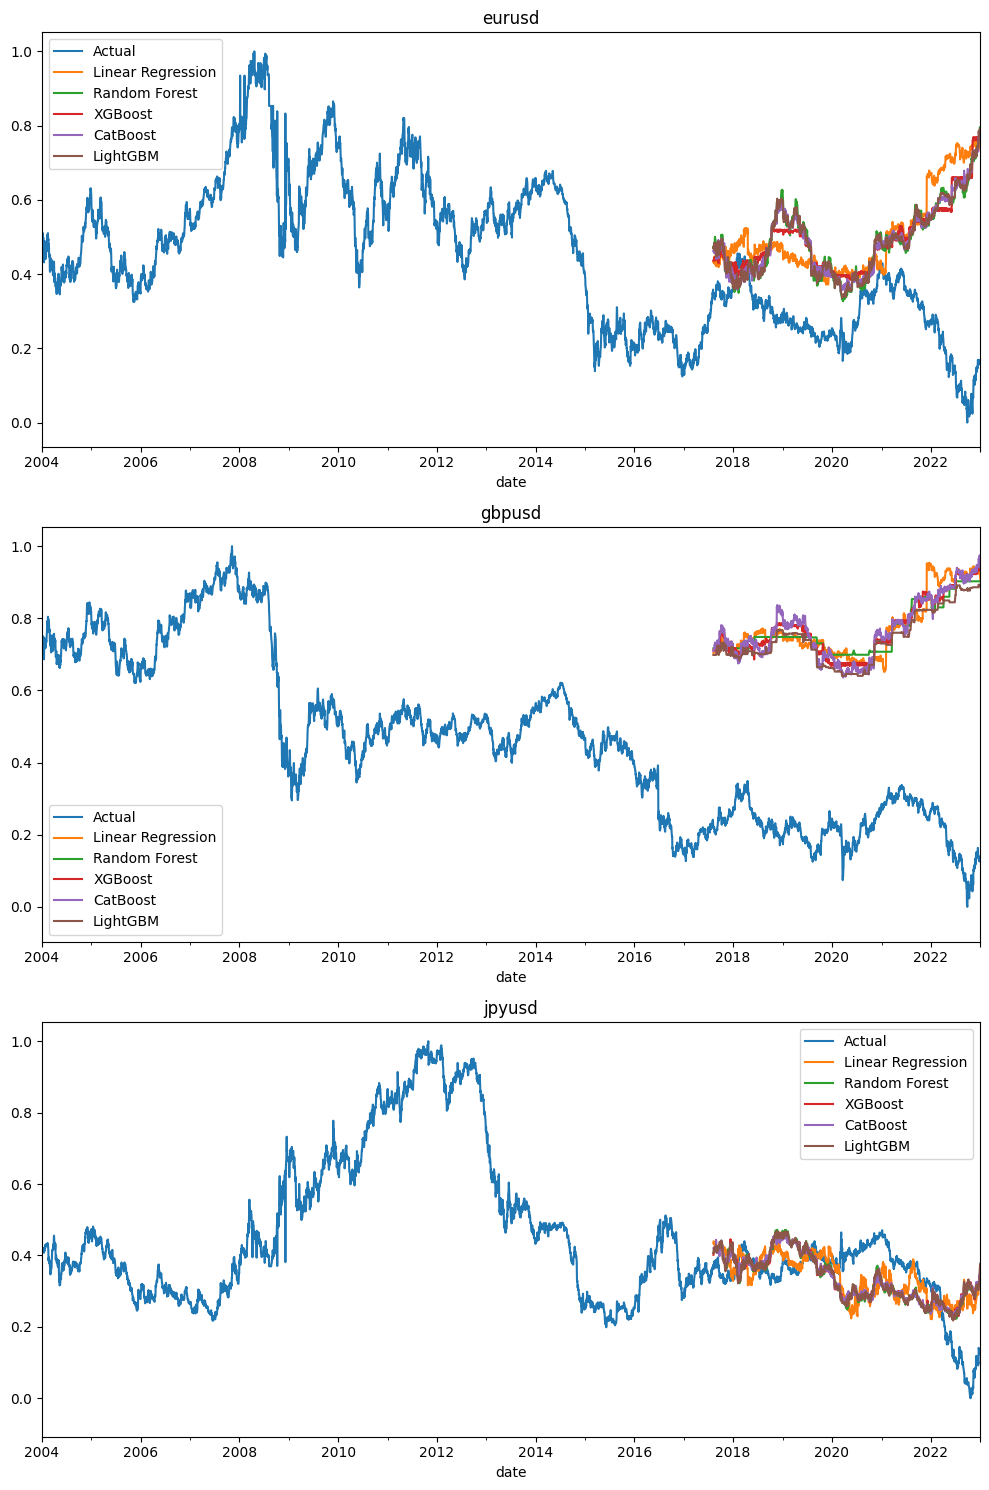

In [70]:
# Visualizar predicciones
fig, axes = plt.subplots(nrows=len(targets), ncols=1, figsize=(10, 15))

for i, target in enumerate(targets):
    ax = axes[i]
    df[target].plot(ax=ax, label='Actual', title=target)
    for model_name, preds in predictions[target].items():
        ax.plot(df.index, preds, label=model_name)
    ax.legend()

plt.tight_layout()
plt.show()
